In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

I have three "cuts" of the data that I want to perform machine learning on:

- all the usable data (i.e. excluding entries that don't have reports)

- the "Auburn" cut, which should remove Vultology reports from authors that have 20 or fewer reports (since they are less experienced)

- the "Lapis" cut, layered over the Auburn cut, which should take into account this analysis:
"I'm seeing something rather suspicious in the data. If I calculate P-axis coordinates with the formula (Suspended - Grounded )/(Suspended + Grounded ), which ranges from -1 (completely Grounded) to +1 (completely Suspended), then there are 90 samples with -1, i.e., Grounded with zero signal mixing.  However, there are only 8 samples in the (-1, -0.9] interval.  In the (-0.9, 0.8] interval there are 40 samples. IMO that strongly suggests that many of those Grounded samples with zero P-axis signal mixing have neglected Suspended signals. The other end of the spectrum also looks suspicious, though it's less extreme. 
There are 36 samples with P-axis coordinates of 1 (Suspended with zero signal mixing), only 3 samples in the [0.9, 1) interval, but 26 samples in the [0.8, 0.9) interval. As for J-axis coordinates, (Measured - Candid)/(Measured + Candid), there are 55 samples with coordinates of 1 (Measured with zero signal mixing), 23 samples in the [0.9, 1) interval, and 35 in the [0.8, 0.9) interval.  There's still an odd dip, but it's a lot less suspicious. At the other end, there are 23 samples with -1 (Candid with zero signal mixing), 12 samples in the (-1, -0.9] interval and 18 samples in the (-0.9, -0.8] interval. It might be worth repeating the statistical analysis reported earlier in this channel just on samples in the (-0.9, 0.9) intervals."

We will see if these different versions of the data give different statistical results or different results in machine learning algorithms.

This notebook is devoted to the Lapis cut of the data. Please read the notebook "Full Data EDA" if you want a primer and what modifications I have already performed on the data to get to this point, since that is what I will be starting from.

## Statistics on the Lapis Cut

In [2]:
lapis_df = pd.read_csv("../Data/Vultology_Database_2024-02-24_-_PlusAuthors_AuburnCut.csv", index_col=0)
lapis_df.head()

,Sample Name,Vultologist,Type,Development,Emotions,Fallen Affect,J Signal Mixing,P Signal Mixing,Sex,Age Range,...,SU8 Quirky Skits,EU1 Responsive Nodding,EU2 Polite Smiling,EU3 Bashful Body Movements,EG1 Upset Mouth Tension,EG2 Assertive Pushing,EG3 Stern Expressions,sum,Lead Energetic,Quadra
1,Michael Gervais,Calin Copil,fesi,i---,neutral,1.0,low,low,male,-1,...,0.0,4.0,4.0,2.0,2.0,4.0,2.0,209.0,Je,Alpha
2,Joan Jett,Calin Copil,seti,i-i-,guarded,2.0,low,low,female,1950s,...,2.0,2.0,2.0,0.0,2.0,4.0,4.0,205.0,Pe,Beta
3,Ben Stein,Calin Copil,site,i---,guarded,2.0,low,low,male,1940s,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,114.0,Pi,Delta
4,Billie Joe Armstrong,Peter Foy,fise,ii-i,neutral,0.0,low,medium,male,1970s,...,0.0,2.0,4.0,2.0,4.0,2.0,4.0,211.0,Ji,Gamma
6,Megyn Kelly,Peter Foy,feni,i---,neutral,0.0,low,low,female,1970s,...,4.0,4.0,4.0,2.0,0.0,7.0,2.0,181.0,Je,Beta


In [3]:
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 1 to 501
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    455 non-null    object 
 1   Vultologist                    455 non-null    object 
 2   Type                           455 non-null    object 
 3   Development                    455 non-null    object 
 4   Emotions                       455 non-null    object 
 5   Fallen Affect                  455 non-null    float64
 6   J Signal Mixing                286 non-null    object 
 7   P Signal Mixing                286 non-null    object 
 8   Sex                            455 non-null    object 
 9   Age Range                      455 non-null    object 
 10  Geography                      455 non-null    object 
 11  Ethnicity                      455 non-null    object 
 12  R1 Rigid Posture               455 non-null    flo

Lapis already described the main alteration that we need to make, so let's just get right to it. The only thing that I want to do which is different from what Lapis suggested is to look at histograms of the distributions of the score formulas he came up, since it's debateable whether we want to include samples in the (-0.9, 0.9) intervals or just exclude the edges, since even the interval (-1, 1), non-inclusive of the absolute extremes, might be approximately normal (the edges strongly violate normality as Lapis already indicated)

We first need to calculate the scores for the 4 quadral axes

In [4]:
lapis_df['Candid Score'] = lapis_df.iloc[:, 42:51].sum(axis=1)
lapis_df['Measured Score'] = lapis_df.iloc[:, 51:60].sum(axis=1)
lapis_df['Grounded Score'] = lapis_df.iloc[:, 60:68].sum(axis=1)
lapis_df['Suspended Score'] = lapis_df.iloc[:, 68:76].sum(axis=1)
lapis_df.iloc[:, 85:].describe()

,Candid Score,Measured Score,Grounded Score,Suspended Score
count,455.000000,455.000000,455.00000,455.000000
mean,18.740659,22.749451,20.12967,13.525275
std,14.602320,15.345036,12.77485,12.142279
min,0.000000,0.000000,0.00000,0.000000
25%,4.000000,8.000000,8.00000,2.000000
50%,17.000000,23.000000,21.00000,10.000000
75%,31.000000,36.000000,30.00000,24.000000
max,57.000000,57.000000,50.00000,47.000000


These are somewhat interesting, the means and medians are mostly pretty similar except maybe for Suspended in which case it's pretty top-heavy (mean > median). However, some of that might be due to the 0 phenomenon that Lapis spoke about.

We need to visualize these scores with histograms (we can also calculate the whole axis like Lapis did)

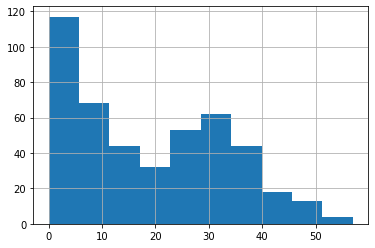

In [5]:
lapis_df['Candid Score'].hist();

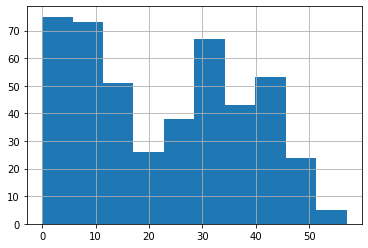

In [6]:
lapis_df['Measured Score'].hist();

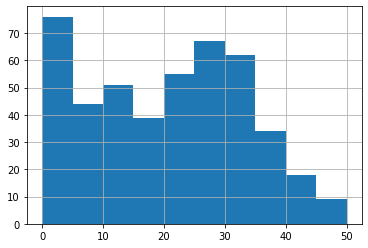

In [7]:
lapis_df['Grounded Score'].hist();

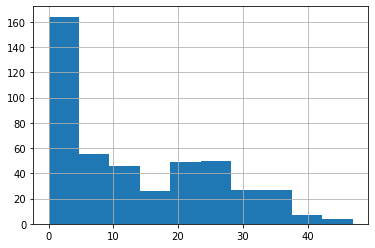

In [8]:
lapis_df['Suspended Score'].hist();

It's mostly the same story of having a huge amount at 0, but also having a second peak somewhere near the 60 percentile. Different aspects are exaggerated for different charts; Suspended has by far the largest peak at 0 which explains why it's mean is so much higher than its median

Now we'll calculate the J-Axis and P-Axis coordinates directly:

In [9]:
lapis_df['J-Axis Coordinate'] = (lapis_df['Measured Score'] - lapis_df['Candid Score'])/(lapis_df['Measured Score'] + lapis_df['Candid Score'])
lapis_df['P-Axis Coordinate'] = (lapis_df['Suspended Score'] - lapis_df['Grounded Score'])/(lapis_df['Suspended Score'] + lapis_df['Grounded Score'])
lapis_df.iloc[:, 89:].describe()

,J-Axis Coordinate,P-Axis Coordinate
count,455.000000,455.000000
mean,0.083957,-0.191005
std,0.686592,0.700072
min,-1.000000,-1.000000
25%,-0.553288,-0.836667
50%,0.224490,-0.414634
75%,0.760000,0.515152
max,1.000000,1.000000


The shifted medians and means are to be expected because Candid and Grounded types are more common in the database

Let's visualize

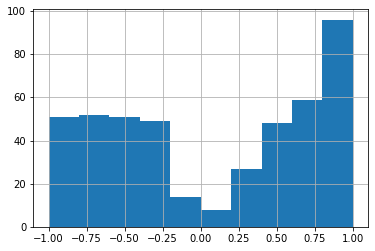

In [10]:
lapis_df['J-Axis Coordinate'].hist();

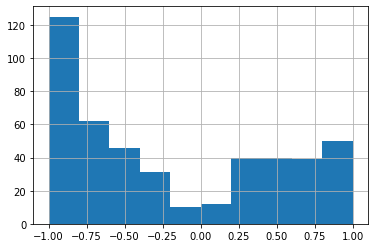

In [11]:
lapis_df['P-Axis Coordinate'].hist();

Hmm, both of these distributions aren't normal at all, but something like a u-quadratic distribution? https://en.wikipedia.org/wiki/U-quadratic_distribution

I think that's something of an illusion though, produced by the numbers of bins in the histogram (which is 10), and what Lapis pointed out about so many extreme values. With the right viewpoint, and with extremes taken out, this looks like it could be almost a bimodal distribution, which is exactly what you want for a typology dichotomy

Let's change the number of bins in the histograms first, to investigate, then let's remove outliers

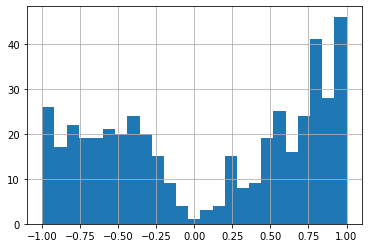

In [12]:
lapis_df['J-Axis Coordinate'].hist(bins=25);

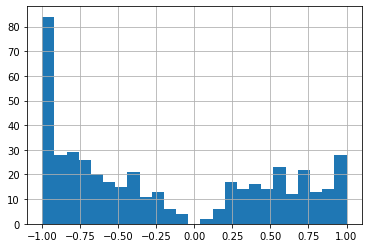

In [13]:
lapis_df['P-Axis Coordinate'].hist(bins=25);

I wouldn't say it's approximately bimodal even excluding the ends, but it's closer to bimodal since you can more easily see how extreme the ends are. Let's see how it looks without them

In [14]:
mask = (lapis_df['Candid Score'] > 0) & (lapis_df['Measured Score'] > 0) & (lapis_df['Grounded Score'] > 0) & (lapis_df['Suspended Score'] > 0)
lapis_df = lapis_df[mask]
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 2 to 497
Data columns (total 91 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    300 non-null    object 
 1   Vultologist                    300 non-null    object 
 2   Type                           300 non-null    object 
 3   Development                    300 non-null    object 
 4   Emotions                       300 non-null    object 
 5   Fallen Affect                  300 non-null    float64
 6   J Signal Mixing                221 non-null    object 
 7   P Signal Mixing                219 non-null    object 
 8   Sex                            300 non-null    object 
 9   Age Range                      300 non-null    object 
 10  Geography                      300 non-null    object 
 11  Ethnicity                      300 non-null    object 
 12  R1 Rigid Posture               300 non-null    flo

So there are exactly 300 samples left which don't have any 0 values for quadra signals, how amusing

In [15]:
lapis_df.iloc[:, 89:].describe()

,J-Axis Coordinate,P-Axis Coordinate
count,300.000000,300.000000
mean,0.073718,-0.120058
std,0.621550,0.606816
min,-0.921569,-0.923077
25%,-0.505000,-0.692308
50%,0.222001,-0.289674
75%,0.686275,0.492021
max,0.923077,0.918367


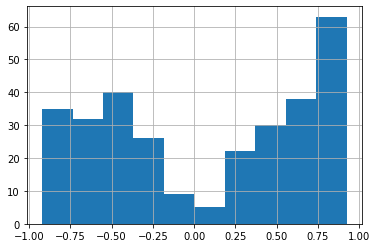

In [16]:
lapis_df['J-Axis Coordinate'].hist(bins=10);

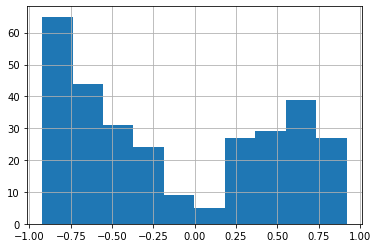

In [17]:
lapis_df['P-Axis Coordinate'].hist(bins=10);

It's still odd how many samples there are near half of the extremes, whereas the other half looks almost bimodal, in both histograms

Let's try more bins again

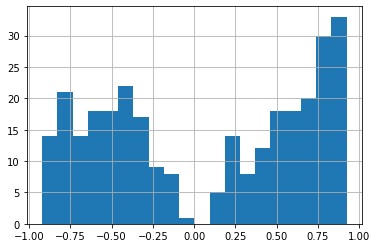

In [18]:
lapis_df['J-Axis Coordinate'].hist(bins=20);

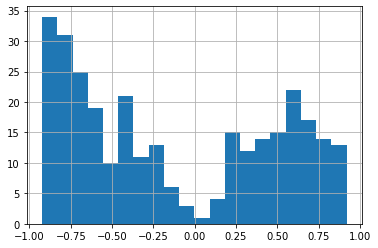

In [19]:
lapis_df['P-Axis Coordinate'].hist(bins=20);

Yeah, it's still something pretty strange, to the point that I don't even know if only including the interval (-0.9, 0.9) will help that much, and I don't know what other interval might improve things (maybe 0.75 to -0.75?)

In [20]:
mask = (lapis_df['J-Axis Coordinate'] > -0.9) & (lapis_df['J-Axis Coordinate'] < 0.9) & (lapis_df['P-Axis Coordinate'] > -0.9) & (lapis_df['P-Axis Coordinate'] < 0.9)
lapis_df = lapis_df[mask]
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 3 to 497
Data columns (total 91 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    266 non-null    object 
 1   Vultologist                    266 non-null    object 
 2   Type                           266 non-null    object 
 3   Development                    266 non-null    object 
 4   Emotions                       266 non-null    object 
 5   Fallen Affect                  266 non-null    float64
 6   J Signal Mixing                202 non-null    object 
 7   P Signal Mixing                200 non-null    object 
 8   Sex                            266 non-null    object 
 9   Age Range                      266 non-null    object 
 10  Geography                      266 non-null    object 
 11  Ethnicity                      266 non-null    object 
 12  R1 Rigid Posture               266 non-null    flo

That removed another 34 samples

In [21]:
lapis_df.iloc[:, 89:].describe()

,J-Axis Coordinate,P-Axis Coordinate
count,266.000000,266.000000
mean,0.040422,-0.114996
std,0.590247,0.589496
min,-0.891892,-0.894737
25%,-0.500000,-0.666667
50%,0.123123,-0.275172
75%,0.607317,0.465385
max,0.894737,0.882353


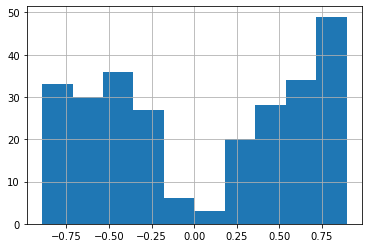

In [22]:
lapis_df['J-Axis Coordinate'].hist(bins=10);

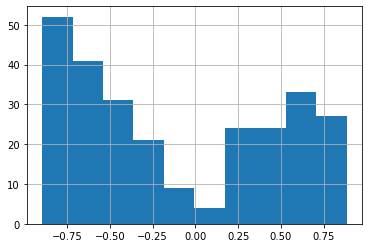

In [23]:
lapis_df['P-Axis Coordinate'].hist(bins=10);

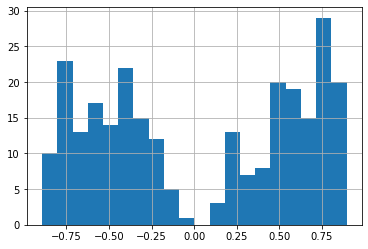

In [24]:
lapis_df['J-Axis Coordinate'].hist(bins=20);

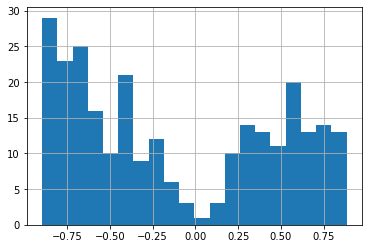

In [25]:
lapis_df['P-Axis Coordinate'].hist(bins=20);

It's just noticeably smoother and less extreme this way, which is good! Though it also reduces the sample size and excludes potentially valuable data, so I'm not sure where the cutoff line should be. I also think a lot of these samples with 0 scores should be re-investigated to check whether they truly have 0 signals or whether one axis was just ignored because "the type was obvious in a gestalt" (not an unreasonable perspective for the amount of effort needed for an accurate diagnostic, but also not the best perspective for producing thorough reports, which can sometimes be opposed incentives)

This is a good insight actually: the incentives for producing the most accurate diagnostic with the least effort, and the incentive of producing the most unbiased and accurate vultology report, are opposed, and that has to be kept in mind when writing vultology reports of the highest quality

I'd also like to check the .75 bounded interval, then I'll stop for now and make a choice since some of this may come down to data quality

In [26]:
mask = (lapis_df['J-Axis Coordinate'] > -0.75) & (lapis_df['J-Axis Coordinate'] < 0.75) & (lapis_df['P-Axis Coordinate'] > -0.75) & (lapis_df['P-Axis Coordinate'] < 0.75)
lapis_df = lapis_df[mask]
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 3 to 470
Data columns (total 91 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    147 non-null    object 
 1   Vultologist                    147 non-null    object 
 2   Type                           147 non-null    object 
 3   Development                    147 non-null    object 
 4   Emotions                       147 non-null    object 
 5   Fallen Affect                  147 non-null    float64
 6   J Signal Mixing                125 non-null    object 
 7   P Signal Mixing                124 non-null    object 
 8   Sex                            147 non-null    object 
 9   Age Range                      147 non-null    object 
 10  Geography                      147 non-null    object 
 11  Ethnicity                      147 non-null    object 
 12  R1 Rigid Posture               147 non-null    flo

Now we're down to a quite small dataset with fewer than 150 samples

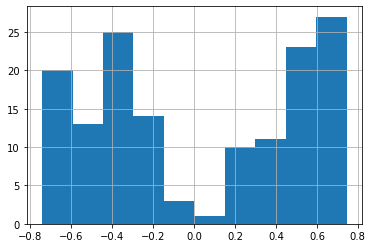

In [27]:
lapis_df['J-Axis Coordinate'].hist(bins=10);

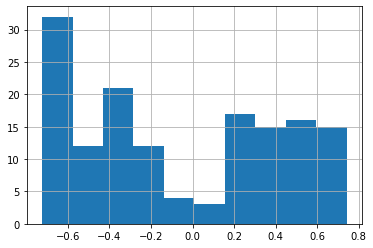

In [28]:
lapis_df['P-Axis Coordinate'].hist(bins=10);

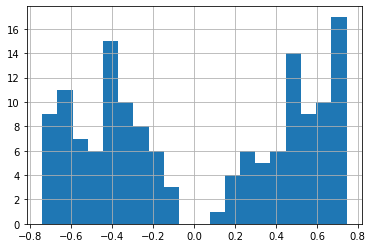

In [29]:
lapis_df['J-Axis Coordinate'].hist(bins=20);

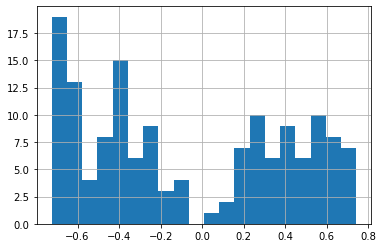

In [30]:
lapis_df['P-Axis Coordinate'].hist(bins=20);

Although these are smoother, they don't impress me with their bimodality, since there are still significant extremes at the ends, gaps, etc.

So I'll probably just go with the original idea for the Lapis cut, but analyzing these possibilities definitely highlights potential issues with the distributions of the quadra signals which are possibly something vultologists should address or look into, either that or we need to think harder about why the distribution of signals looks the way that it does

In [31]:
lapis_df = pd.read_csv("../Data/Vultology_Database_2024-02-24_-_PlusAuthors_AuburnCut.csv", index_col=0)
lapis_df['Candid Score'] = lapis_df.iloc[:, 42:51].sum(axis=1)
lapis_df['Measured Score'] = lapis_df.iloc[:, 51:60].sum(axis=1)
lapis_df['Grounded Score'] = lapis_df.iloc[:, 60:68].sum(axis=1)
lapis_df['Suspended Score'] = lapis_df.iloc[:, 68:76].sum(axis=1)
lapis_df['J-Axis Coordinate'] = (lapis_df['Measured Score'] - lapis_df['Candid Score'])/(lapis_df['Measured Score'] + lapis_df['Candid Score'])
lapis_df['P-Axis Coordinate'] = (lapis_df['Suspended Score'] - lapis_df['Grounded Score'])/(lapis_df['Suspended Score'] + lapis_df['Grounded Score'])
mask = (lapis_df['J-Axis Coordinate'] > -0.9) & (lapis_df['J-Axis Coordinate'] < 0.9) & (lapis_df['P-Axis Coordinate'] > -0.9) & (lapis_df['P-Axis Coordinate'] < 0.9)
lapis_df = lapis_df[mask]
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 3 to 497
Data columns (total 91 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    266 non-null    object 
 1   Vultologist                    266 non-null    object 
 2   Type                           266 non-null    object 
 3   Development                    266 non-null    object 
 4   Emotions                       266 non-null    object 
 5   Fallen Affect                  266 non-null    float64
 6   J Signal Mixing                202 non-null    object 
 7   P Signal Mixing                200 non-null    object 
 8   Sex                            266 non-null    object 
 9   Age Range                      266 non-null    object 
 10  Geography                      266 non-null    object 
 11  Ethnicity                      266 non-null    object 
 12  R1 Rigid Posture               266 non-null    flo